# Structured light

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
from scipy.spatial.transform import Rotation
from scipy.optimize import least_squares
import scipy.ndimage
from skimage import color
import skimage

In [2]:
def Pi(points):
    n,p = points.shape
    new_points = np.vstack((points, np.ones(p)))
    return new_points

def PiInv(points):
    n,p = points.shape
    new_points = points[:-1]/points[-1]
    return new_points

## 3D scanning

In [3]:
c = np.load('casper/calib.npy', allow_pickle=True).item()

In [4]:
c

{'K0': array([[1.09058826e+03, 0.00000000e+00, 4.22000000e+02],
        [0.00000000e+00, 1.09058826e+03, 3.38000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'd0': array([-0.03720395, -0.2353958 ,  0.        ,  0.        ,  0.        ]),
 'K1': array([[1.09454675e+03, 0.00000000e+00, 4.22000000e+02],
        [0.00000000e+00, 1.09454675e+03, 3.38000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'd1': array([-0.04744541, -0.00026868,  0.        ,  0.        ,  0.        ]),
 'R': array([[ 0.91398722, -0.07814026,  0.39814758],
        [ 0.07619891,  0.99687725,  0.02072451],
        [-0.39852369,  0.01139647,  0.91708726]]),
 't': array([[-407.240143 ],
        [  -1.5053668],
        [  85.688652 ]])}

### Exercise 13.1

If the cameras were not calibrated, you would need to calibrate them first.
How would you find their intrinsics?
What about the extrinsics?

Calibrate is giving K (intrinsics) and R, t (extrinsics) for each camera

See week 4 for pocedure

Needed: coordonates of 3D points on casper and associated coord of this points in camera 1 and 2

### Exercise 13.2

In [5]:
im0 = cv2.imread("casper/sequence/frames0_0.png")
size = (im0.shape[1], im0.shape[0])
stereo = cv2.stereoRectify(c['K0'], c['d0'], c['K1'],
c['d1'], size, c['R'], c['t'], flags=0)
R0, R1, P0, P1 = stereo[:4]
maps0 = cv2.initUndistortRectifyMap(c['K0'], c['d0'], R0, P0, size, cv2.CV_32FC2)
maps1 = cv2.initUndistortRectifyMap(c['K1'], c['d1'], R1, P1, size, cv2.CV_32FC2)

In [6]:
im0 = np.mean(cv2.imread("casper/sequence/frames0_0.png")/255,axis=2)
im0.shape

(676, 844)

In [7]:
ims0 = []
ims1 = []

for i in range(26):
    im0 = np.mean(cv2.imread(f"casper/sequence/frames0_{i}.png")/255,axis=2)
    im1 = np.mean(cv2.imread(f"casper/sequence/frames1_{i}.png")/255,axis=2)
    
    
    im0 = cv2.remap(im0, *maps0, cv2.INTER_LINEAR)
    im1 = cv2.remap(im1, *maps1, cv2.INTER_LINEAR)
    
    ims0.append(im0)
    ims1.append(im1)

In [8]:
ims1[8].shape

(676, 844)

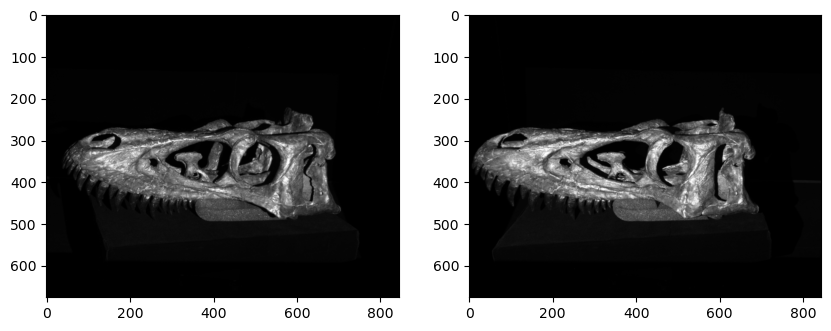

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(ims0[0],cmap='gray')
ax[1].imshow(ims1[0],cmap='gray')
plt.show()

### Exercise 13.3

In [10]:
def unwrap(ims):
    primary = ims[2:18]
    secondary = ims[18:]
    n1 = 40 # see nb of periods
    fft_primary = np.fft.rfft(primary, axis=0)
    theta_primary = np.angle(fft_primary[1])
    fft_secondary = np.fft.rfft(secondary, axis=0)
    theta_secondary = np.angle(fft_secondary[1])
    theta_c = (theta_secondary - theta_primary) %(2*np.pi) ## take modulo !
    o_primary = np.round((n1*theta_c-theta_primary)/2/np.pi)
    theta = (2*np.pi*o_primary + theta_primary)/n1
    return theta

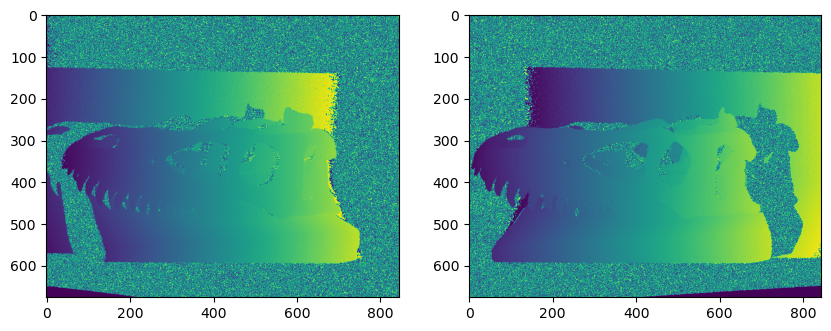

In [11]:
theta0 = unwrap(ims0)
theta1 = unwrap(ims1)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(theta0)
ax[1].imshow(theta1)
plt.show()

In [13]:
# debugging
plt.plot(theta_primary[200,:200])
plt.plot(theta_secondary[200,:200])
#plt.show()
plt.plot(theta_c[200,:200]%(2*np.pi))

NameError: name 'theta_primary' is not defined

### Exercise 13.4

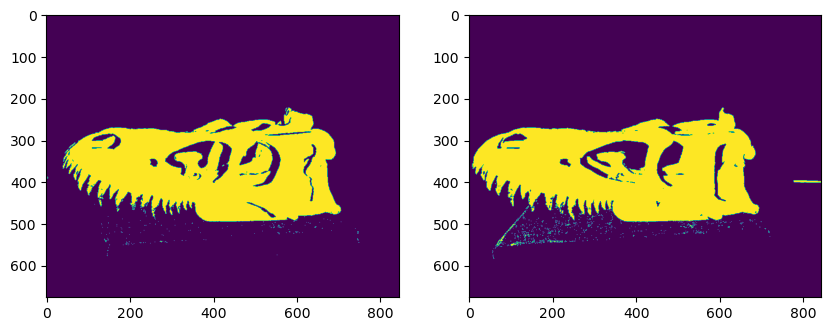

In [14]:
dif = ims0[0]-ims0[1]
dif = (dif - np.min(dif))*255
dif = dif.astype('uint8')
mask0 = dif>15

dif = ims1[0]-ims1[1]
dif = (dif - np.min(dif))*255
dif = dif.astype('uint8')
mask1 = dif>15

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(mask0)
ax[1].imshow(mask1)
plt.show()

### Exercise 13.5

In [15]:
q0s = []
q1s = []
disparity = np.zeros(theta0.shape)

n,m = theta0.shape
for i0 in range(n):
    for j0 in range(m):
        if mask0[i0,j0] == True:
            q0s.append([j0,i0])
            diff = abs(theta1[i0,:] - theta0[i0,j0])
            diff[mask1[i0,:]==False] = np.max(diff)
            j1 = np.argmin(diff)
            q1s.append([j1,i0])
            disparity[i0,j0] = j0 - j1     

In [17]:
disparity[360, 400]

-21.0

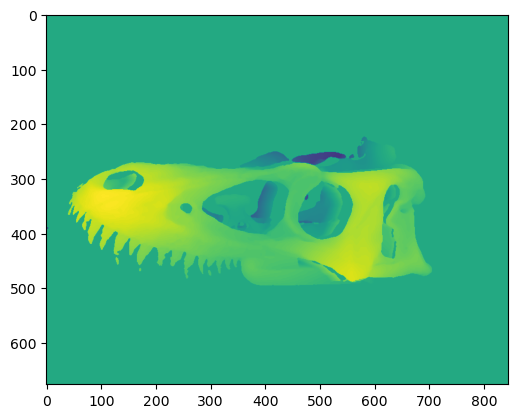

In [16]:
plt.imshow(cv2.medianBlur(disparity.astype(np.float32), 5))

### Exercise 13.6

In [168]:
q0 = np.array(q0s).T/255
q1 = np.array(q1s).T/255

In [173]:
Q = cv2.triangulatePoints(P0,P1,q0,q1)
Q = PiInv(Q)

In [158]:
Qnew = []
for i in range(Q.shape[1]):
    if Q[2,i] >= 0:
        Qnew.append(Q[:,i])

In [177]:
np.min(Q[2,:])

858.4444204998566

In [165]:
%matplotlib qt

In [ ]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Q.T)
o3d.visualization.draw_geometries([pcd])